# Interactive Surrogate Modelling

In this notebook we:
+ define a problem consisting of parameters to vary with ranges and an objective function
+ sample the problem space
+ define an Evaluator by linking the problem to an EnergyPlus model
+ run the Evaluator for the samples
+ train a surrogate model over the samples
+ explore the design space using an interactive plot that queries the surrogate model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from sklearn import svm, pipeline, linear_model
from sklearn.preprocessing import StandardScaler

from besos import eppy_funcs as ef
from besos import sampling
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, Parameter, FieldSelector
from besos import config

## Parameters and Objectives
We start by defining `Parameters` that govern how we would like to modify the building.  
Here they are the solar heat gain coefficient and the lighting power density. 

In [2]:
parameters = [
    Parameter(FieldSelector(object_name='NonRes Fixed Assembly Window',
                                field_name='Solar Heat Gain Coefficient'),
                  value_descriptor=RangeParameter(0.01,0.99)),
    Parameter(FieldSelector('Lights', '*', 'Watts per Zone Floor Area'),
                  value_descriptor=RangeParameter(8, 12),
                  name='Lights Watts/Area')]

Now, we specify that we would like to optimize for electricity use of the entire facility. We then bundle all of this information together.

In [3]:
objectives = ['Electricity:Facility']

problem = EPProblem(parameters, objectives)

## Sampling

We need to generate samples on which to train a surrogate model.  
The `sampler` uses Latin Hypercube Sampling to distribute the samples in the design space defined by the `Parameters`.  
We can check how well distributed they are using `describe()`.

In [4]:
inputs = sampling.dist_sampler(sampling.lhs, problem, 5)
inputs.describe() # properties of the sample set

,Solar Heat Gain Coefficient,Lights Watts/Area
count,5.000000,5.000000
mean,0.506860,10.040531
std,0.312148,1.058007
min,0.038625,8.700740
25%,0.385948,9.333161
50%,0.591445,10.199721
75%,0.655612,10.551767
max,0.862668,11.417265


## Building model
Next we load an EnergyPlus model. The example is a small office, or we could pass in the IDF filename.

In [5]:
building = ef.get_building()

## Evaluator
We now define and run the Evaluator, which will run the EnergyPlus instances with the different inputs generated in the previous cell. 

In [6]:
evaluator = EvaluatorEP(problem, building)
train = evaluator.df_apply(inputs, keep_input=True)
train.head() # first 5 lines

,Solar Heat Gain Coefficient,Lights Watts/Area,Electricity:Facility
0,0.385948,10.199721,1.815945e+09
1,0.038625,10.551767,1.741947e+09
2,0.655612,11.417265,1.988845e+09
3,0.591445,8.700740,1.785228e+09
4,0.862668,9.333161,1.956404e+09


We can save results at this point:

In [7]:
train.to_pickle('samples.p')

And load them again later:

In [8]:
train = pd.read_pickle('samples.p')

## Exploring the training data
Let's look at the correlation amongst the inputs and the output using a built-in [Seaborn](http://seaborn.pydata.org/) plot:

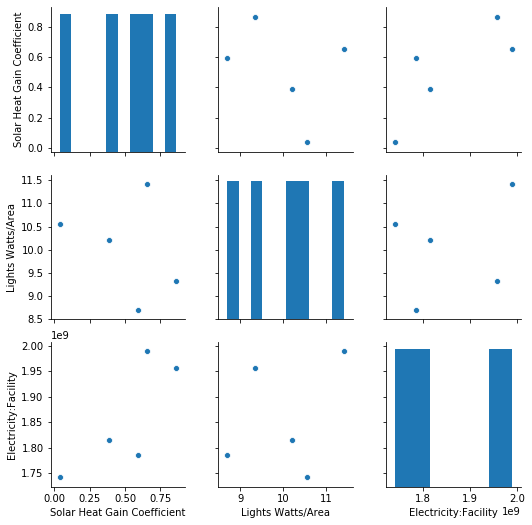

In [9]:
g = sns.pairplot(train)

Here's a plot of the _design space_ defined by the samples.

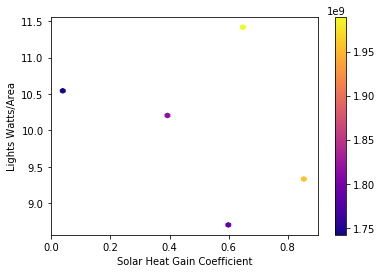

In [10]:
x,y,obj = problem.names()
train.plot.hexbin(x=x, y=y, C=obj, cmap='plasma', sharex=False, gridsize=50)

## Fitting a surrogate model

Now we can train the model using a ScikitLearn pipeline:

In [11]:
model = pipeline.make_pipeline(
        StandardScaler(),
        linear_model.Ridge())
model.fit(train[[x, y]].values, train[obj].values)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

## Running the surrogate model

We can query the model at a specific point in the design space:

In [12]:
model.predict([[0.5,10]])

array([1.85386632e+09])

Or for a `dataframe` made from a `dictionary` of points:

In [13]:
points = pd.DataFrame(data={'SHGC': [0, 1], 'LPD': [8, 12]})
model.predict(points)

array([1.62187113e+09, 2.08586150e+09])

Next we define a function for querying the surrogate model across the domain at a given density, and plot the result.

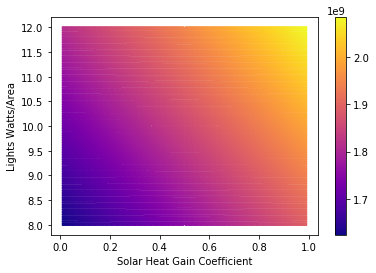

In [14]:
def run_model(model, density):
    p1 = problem.inputs[0].value_descriptor
    a = np.linspace(p1.min, p1.max, density)
    p2 = problem.inputs[1].value_descriptor
    b = np.linspace(p2.min, p2.max, density)
    plot_data = pd.DataFrame(np.transpose([np.tile(a, len(b)), np.repeat(b, len(a))]),
                             columns=problem.names('inputs'))
    return pd.concat([plot_data, pd.Series(model.predict(plot_data))], axis=1)

density = 200
df = run_model(model, density)
df.plot.hexbin(x=x, y=y, C=0, cmap='plasma', gridsize=density, sharex=False)

## Interactive surrogate
Finally we make an interactive plot using `ipywidgets`, which executes the model every time a slider is moved.

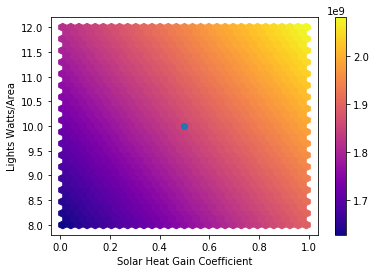

'Electricity use = 515.0 kWh'

<function __main__.model_wrapper(v1, v2)>

In [15]:
# get the min and max of the two variables
(min1, max1), (min2, max2) = ((float(p.value_descriptor.min ), p.value_descriptor.max)
                              for p in problem.inputs)
# get the data to plot in the background
df = run_model(model, 100)

# define a wrapper to be queried by interact
def model_wrapper(v1, v2):
    df.plot.hexbin(x=x, y=y, C=0, cmap='plasma', gridsize=30, sharex=False) # background plot
    x_lims = plt.xlim()
    y_lims = plt.ylim()
    plt.scatter(x=v1, y=v2) # plot the marker
    plt.xlim((x_lims))
    plt.ylim((y_lims))
    
    value = model.predict([[v1, v2]])[0] / 3.6e6 # find the current value and convert to kWh
    output = 'Electricity use = ' + str(value.round()) + ' kWh' # return the string to display
    return output

# make the interactive plot with two sliders
continuous_update=False
interact(model_wrapper,
         v1=FloatSlider(min=min1, max=max1, value=(min1+max1)/2, description='SHGC',
                                step=0.01, continuous_update=continuous_update),
         v2=FloatSlider(min=min2, max=max2, value=(min2+max2)/2, description='LPD [W/m2]',
                           continuous_update=continuous_update))